In [1]:
import eigenEFull
import numpy as np
import matplotlib.pyplot as plt

**Note**: Relative links won't work on GitHub. Run via Jupyter to get functionality.

# 1. Symbols and notation
### Symbols
- $\textbf{u} = (u,v,w)$ is the velocity. The components are the $(r,\phi,z)$ components in cylindrical polar coordinates respectively.
- $\rho$ is the density.
- $\Phi$ is the gravitational potential.
- $p$ is the pressure.
- $\mu$ and $\mu_b$ are viscosity and bulk viscosity.
- $\alpha$ and $\alpha_b$ are viscosity parameters defined by $\mu = \alpha p/\Omega = \alpha c_s^2 \rho / \Omega$.
- $\textbf{T}$ is the stress tensor.
- $\Sigma := \int \rho dz$ is the surface density.
- $\epsilon^2 << 1$ is the asymptotic parameter which we expand usually to first order.
- $\tau := \epsilon^2 t$ is scaled time.
- $\zeta := z/\epsilon$ is scaled height.
- $\Omega$ is the angular velocity.
- $c_s := p/\rho$ is the isothermal sound speed.
- $H := c_s/\Omega$ is the scale-height.

### Notation
For $a(x)$ for some variable $x$:
- $a'$ is a perturbation of $a$.
- $a_i := a(x_i)$.
- $a_p(x)$ is the function $a(x)$ for a planet.

# 2. Equations of Eccentricity

## 2.1 Equations

The full equation of eccentricity evolution is:

$$ 2ir\Omega \Sigma \frac{\partial E}{\partial \tau} = -\frac{1}{r^2} \frac{\partial}{\partial r}\bigg(\Sigma c_{s}^2 r^3 \frac{\partial E}{\partial r}\bigg)
-\frac{d}{dr} \bigg(\Sigma c_s^2 \bigg) E
+ \frac{1}{r^2} \frac{\partial}{\partial r} \bigg(\Sigma \frac{dc_s^2}{dr} r^3 E \bigg)
+ \bigg[ \frac{3 i W c_s^2 \Sigma}{\Omega r} + \frac{3 E c_s^2 \Sigma}{r} \bigg] + S$$

Where:
$$ S = \int{\bigg( \frac{1}{r} \frac{\partial}{\partial r}(r T_{rr0}') + \frac{2i}{r^2} \frac{\partial}{\partial r}(r^2 T_{r \phi 0}') - \frac{i}{r} T_{r \phi 0}' - \frac{2i \rho_0'}{\rho_0 r^2} \frac{\partial}{\partial r}(r^2 T_{r \phi 0}) \bigg) d\zeta  } $$

$$ W = - \frac{\Omega}{i + \frac{4}{3}\alpha + \alpha_b} \bigg( 3E + \frac{r}{c_s^2} \frac{dc_s^2}{dr} E + (\alpha_b - \frac{2}{3} \alpha) i r \frac{\partial E}{\partial r} \bigg) $$

### Notes
- The terms in square brackets are those from 3D effects. For 2D considerations we can remove them.
- I typically worked with $\alpha=0$ and $\alpha_b<<1$ to avoid having to work with the full stress tensor. 

## 2.2 Numerical Method
We look fo solutions of the form $E(r,t) = E(r) e^{i \omega t}$. This simplifies the evolution equation to one only depending on $r$.

We then solve using a finite difference method with finite difference matrices $D$ and $D^{(2)}$.

The equation then becomes (summing over the j,k indices):
$$ 2 r_i \Omega_i \omega \Sigma_i E_i = r_i^{-3} D_{ij} \Sigma_j c_{s,j}^2 r_j^2 D_{ik} E_k + 
\Sigma_i c_{s,i}^2 r_i^{-1} D_{ij}^{(2)} E_j + 
r_i^{-1} D_{ij} \Sigma_j c_{s,j}^2 E_i - 
r_i^{-3} D_{ij} \Sigma_j r_j^2 E_j D_{ik} c_{s,k}^2 - 
D_{ij}^{(2)} c_{s,j}^2 \Sigma_i r_i^{-1} E_i -
\bigg[ \frac{3i W_i c_{s,i}^2 \Sigma_i}{\Omega_i r_i} + \frac{3E_i c_{s,i}^2 \Sigma_i}{r_i} \bigg]-
S_i$$

Which we turn into a matrix eigenvalue problem by:
$$M_{ij} E_j =\omega E_i $$
Where (noting that k is summed over)
$$M_{ij} = \bigg( r_i^{-3} D_{ik} \Sigma_k c_{s,k}^2 r_k^2 D_{ij}+
\Sigma_i c_{s,i}^2 r_i^{-1} D_{ij}^{(2)}+
r_i^{-1} D_{ik} \Sigma_k c_{s,k}^2 \delta_{ij}-
r_i^{-3} D_{ij} \Sigma_j r_j^2 D_{ik} c_{s,k}^2-
D_{ik}^{(2)} c_{s,k}^2 \Sigma_i r_i^{-1} \delta_{ij}+
\frac{3}{r_i^3} \Sigma_i D_{ik} c_{s,k}^2 r_k^2 \delta_{ij}+
viscous terms \bigg)/ \bigg( \frac{2 \Sigma_i}{\sqrt{r}} \bigg)$$

These first 6 terms are referred to as ```A1```, ```B1```, ```C1```, ```D1```, ```E1``` and ```F1``` by the code. `F1` is the 3D effect.

## 2.3 Selecting physical eigenvectors
The code then calculates the eigenvalues ($\omega$) and eigenvectors ($E$) of this matrix, and these are output as `w` and `v` respectively. However, once this completes we will see that we have created a number of spurious eigenvectors which do not represent any physical output. So the final task is to sort through the full eigenvector list to find those which are physical. There isn't a concrete way of doing this every time, but there are several ways of narrowing down your selection, such as:

- Checking for the number of zeros (only in inviscid solution)
- Checking how often the absolute value decreases
- Checking the number of turning points

Usually we are checking for that the solution has the expected continuity that a physical system would have.

# 3. Simple Inviscid Solution

For both of these we are using the simple case of $\alpha = \alpha_b = 0$. These results are similar to those of section 5 of [Teyssandier & Ogilvie (2016)](<#ref1>).

In both cases we use sound speed $c_s = \Omega H = \epsilon r \Omega (1-\sqrt{r_{in}/r})^{2/9}$ as well as
$$\Sigma = \Sigma_0 \bigg(\frac{r}{r_0} \bigg)^{-1/2} \bigg(1-\sqrt{ \frac{r_{in}}{r} } \bigg)^{-5/9} $$
These are both the default inputs.

## 3.1 2D Solution

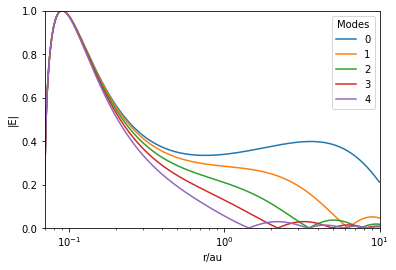

In [2]:
E, Ep, w1, r, w, v = eigenEFull.eigenEF(0.07,10,0.05,n=2000,a=0,is3d=False)

## 3.2 3D Solution

1998


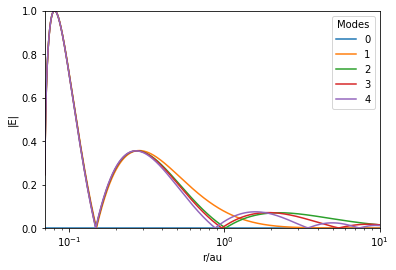

In [3]:
E, Ep, w1, r, w, v = eigenEFull.eigenEF(0.07,10,0.05,n=2000,a=0,is3d=True)

# 4. Additional terms in the formula

This is where it gets messy. These introduce new terms to the [eccentricity evolution equation](<#2.-Equations-of-Eccentricity>).

## 4.1 Bulk viscosity
The contribution is
$$
2 i r \Omega \Sigma \bigg( \frac{\partial E}{\partial t} \bigg)_{\alpha_b} = i \alpha_b \Bigg( - \bigg( \frac{3 c_s^2}{r} + \frac{d c_s^2}{d r} \bigg) \Sigma E + r \frac{ \partial}{\partial r} \bigg( c_s^2 \Sigma \frac{ \partial E}{\partial r} \bigg) + \frac{\partial}{\partial r} \bigg( \Big( 3 c_s^2 + r \frac{d c_s^2}{d r} \Big) \Sigma E \bigg) \Bigg)
$$
Which becomes
$$
2 i r \Omega \Sigma \bigg( \frac{\partial E}{\partial t} \bigg)_{\alpha_b} = i \alpha_b \Bigg( - \bigg( \frac{3 c_s^2}{r} +
\frac{d c_s^2}{d r} \bigg) \Sigma E +
r \frac{ \partial}{\partial r} \bigg( c_s^2 \Sigma \bigg) \frac{ \partial E}{\partial r} +
r c_s^2 \Sigma \frac{ \partial^2 E}{\partial r^2} + 
\frac{\partial}{\partial r} \bigg( 3 c_s^2 \Sigma \bigg) E +
3 c_s^2 \Sigma \frac{\partial E}{\partial r} +
\frac{d c_s^2}{d r} \Sigma E+
r \frac{d^2 c_s^2}{d r^2} \Sigma E+
r \frac{d c_s^2}{dr} \Sigma \frac{\partial E}{\partial r} + 
r \frac{d c_s^2}{d r} \frac{\partial \Sigma}{\partial r} E \Bigg)
$$

These are labelled `H1`, `H2`, `H3`, `H4`, `H5`, `H6`, `H7`, `H8`, `H9` in the code respectively.

## 4.2 Secular interactions with companion

The additional terms introduced to the eccentricity equation are given on the right-hand-side below:

$$
2 i r \Omega \Sigma \bigg( \frac{\partial E}{\partial t} \bigg)_p = -\frac{G M_p \Sigma}{2 a_p^2} \bigg(
b_{3/2}^{(1)}(\beta) E - b_{3/2}^{(2)} E_p \bigg)
$$

These are labelled ```G1``` and ```G2``` respectively. 

Note that the Laplace coefficient is defined as

$$
b_s^{(j)}(\beta) = \frac{1}{\pi} \int_0^{2 \pi} \frac{cos(j \psi)}{(1 - 2 \beta cos \psi + \beta^2)^s} d\psi
$$

and $\beta = r/a_p$ in this case. In the case when the disc is outside the orbit of the companion, i.e. $r > a_p$, this still holds but with $\beta a_p / r$ (so $\beta < 1$). In the code we avoid this switching by using the `beta` function (see below), with softening parameter = 0 (this just picks $r / a_p$ or $a_p / r$ depending on which one is $< 1$).

## 4.3 Self-gravity

This is derived in a similar way to the above, with contribution:

$$
2 i r \Omega \Sigma \bigg( \frac{\partial E}{\partial t} \bigg)_d = - 
\frac{\pi G \Sigma}{r^{3/2}} \int \Sigma(r') \beta^{3/2} r'^{1/2} \bigg( b_{3/2}^{(1)} E(r,t) - b_{3/2}^{(2)} E(r',t) \bigg) dr'
$$

These are labelled ```I1``` and ```I2``` in the code. 

However I also (very helpfully) use a different definition of $\beta$, defined as the solution to:
$$
\frac{1 + \beta^2}{\beta} = \frac{r^2 + r'^2 + b^2}{r r'}
$$
where $\beta < 1$ and $b$ is a softening parameter which in practice we'll set to $\epsilon$. The `beta` function in the code calculates this value.

## 4.4 Resonances

This is mostly following from analyses from [Ogilvie (2007)](#ref2) and [Teyssandier & Ogilvie (2016)](#ref1).

### 4.4.1 Lindblad Resonances

$$
2 i r \Omega \Sigma \bigg( \frac{\partial E}{\partial t} \bigg)_{ELR} = \frac{2 i G M_p^2}{r M} \Sigma \mathscr{A} ( \mathscr{A} E - \mathscr{B} E_p ) w_L^{-1} \Delta \bigg( \frac{r-r_{res}}{w_L} \pm 1 \bigg)
$$

Where:
- $\mathscr{A}, \mathscr{B}, \mathscr{C}, \mathscr{D}$ are dimensionless constants defined in table 2 of [Teyssandier & Ogilvie (2016)](#ref1)
- $\Delta(x) := (2 \pi)^{-1/2} exp(-x^2/2)$
- $w_L$ is the width of the resonance, found to be (for some integer $j$)
$$
\frac{w_L}{r} \approx \bigg( \frac{\epsilon^2}{3(j \mp 1 - 1)} \bigg)^{1/3}
$$

These are calculated for inner (- sign in $w_L$ calculation) and outer (+ sign in $w_L$ calculation). Then summed to the ```LR``` variable, and summed again to make ```LR1```. The script constants ($\mathscr{A}$...) are defined for 11 resonances in the code as e.g. ```IAs``` is a list containing $\mathscr{A}$ for inner resonances; ```OAs``` a list for outer resonances.

### 4.4.2 Corotation Resonances

$$
2 i r \Omega \Sigma \bigg( \frac{\partial E}{\partial t} \bigg)_{ECR} = \pm \frac{2 i G M_p^2}{rM} \frac{d ln \frac{\Sigma}{\Omega}}{d ln r} \Sigma \mathscr{C} ( \mathscr{C} E - \mathscr{D} E_p ) w_C^{-1} \Delta \bigg( \frac{r-r_{res}}{w_L} \bigg)
$$

Where:
- $\mathscr{A}, \mathscr{B}, \mathscr{C}, \mathscr{D}$ are dimensionless constants defined in table 2 of [Teyssandier & Ogilvie (2016)](#ref1)
- $\Delta(x) := (2 \pi)^{-1/2} exp(-x^2/2)$
- $w_L$ is the width of the resonance, found to be (for some integer $j$)
$$
\frac{w_C}{r} \approx 4.1 \bigg( C_{j-1}^{\pm} (j-1)e \frac{M_p}{M} \bigg)^{1/2}
$$

where:
- $C_{j-1}^{\pm}$ are constants that can be looked up from Tables 1 and 2 in [Ogilvie & Lubow (2003)](#ref3). These are ```ICM``` and ```OCM``` in the code.
- e is the value of eccentricity (either that for the disc, the planet or some combination of the two).

These are calculated for inner (- sign in $w_C$ calculation) and outer (+ sign in $w_C$ calculation). Then summed to the ```CR``` variable, and summed again to make ```CR1```.

## 4.5 Back reaction on the companion

The effects in section 4.2-4.4 can be reversed to find the effect on the companion. These are

$$
2 i r a_p \Omega_p M_p \bigg( \frac{\partial E_p}{\partial t} \bigg)_d = - 
\frac{\pi G M_p}{a_p^{3/2}} \int \Sigma \beta^{3/2} r^{1/2} \bigg( b_{3/2}^{(1)} E_p - b_{3/2}^{(2)} E(r,t) \bigg) dr
$$

$$
2 i a_p \Omega_p M_p \bigg( \frac{\partial E_p}{\partial t} \bigg)_{ELR} = \frac{4 i \pi G M_p^2}{a_p M} \int \Sigma \mathscr{B} ( \mathscr{B} E_p - \mathscr{A} E ) w_L^{-1} \Delta \bigg( \frac{r-r_{res}}{w_L} \pm 1 \bigg) r dr
$$

$$
2 i a_p \Omega_p M_p \bigg( \frac{\partial E_p}{\partial t} \bigg)_{ECR} = \pm \frac{4 i \pi G M_p^2}{a_p M} \frac{d ln \frac{\Sigma}{\Omega}}{d ln r} \int \Sigma \mathscr{D} ( \mathscr{D} E_p - \mathscr{C} E ) w_C^{-1} \Delta \bigg( \frac{r-r_{res}}{w_L} \bigg) r dr
$$

Inclusion of these back reaction effects is same as adding an extra row and column to the matrix when calculating numerically. Thus, in the code, they are represented by `M[i,n]`, `M[n,n]` and `M[n,i]`.

# 5. Cataclysmic Variable Stars
This is following the analysis of [Goodchild & Ogilvie (2006)](#ref4). The difference being that their's was a two-dimensional analysis but mine was a three-dimensional analysis. I replicated the results and showed that while the three-dimensional approach is an improvement on the two dimensional version, it does not quite match the observed precession rates. Further, non-linear analysis would be required.

In [4]:
def cs(r,eps,rin,**kwargs):
    return eps*1/r**(3/8)*(1-(rin/r)**(1/2))**(3/20)

def s(r,rin,rout,**kwargs):
    return r**(-3/4)*(1 - (rin/r)**(1/2))**0.7*np.tanh((rout-r)/(0.01*rout))

In [5]:
_, _, _, r, w, v = eigenEFull.eigenEF(0.01,0.531,0.006,n=2000,a=0.05,q=0.1,ap=1,is3d=True,cs=cs,s=s,plot=False)

Agreement


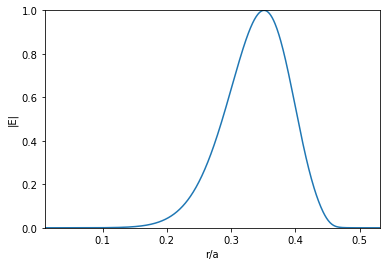

In [6]:
axes_sort = eigenEFull.rank(v)

fig, ax = plt.subplots()
ax.set_xlabel('r/a')
ax.set_ylabel('|E|')
ax.set_xscale('log')
ax.set_xlim((0.01,0.531))
ax.set_ylim((0,1))
ax.plot(r,abs(v[:,axes_sort[0]]))
ax.legend()
plt.show()

# 6. Protoplanetary disc

In [7]:
_, _, _, r, w, v = eigenEFull.eigenEF(0.05,10,0.05,n=2000,a=0.004,q=0.003,qd=0.00015,ap=0.03,plot=False)

In [8]:
axes_sort = eigenEFull.rank(v)

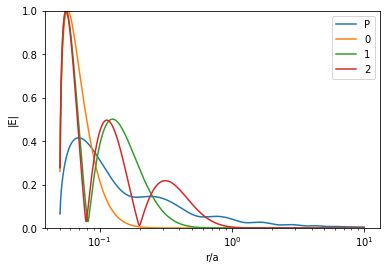

In [9]:
fig, ax = plt.subplots()
ax.set_xlabel('r/a')
ax.set_ylabel('|E|')
ax.set_xscale('log')
ax.set_ylim((0,1))
labels = ['P','0','1','2']
ax.plot(r,abs(v[:,axes_sort[0:4]]), label=labels)
ax.legend()
plt.show()

# References

<a name='ref1'></a>
Teyssandier, J. & Ogilvie, G. I., 2016, [MNRAS, 458, 3221–3247](https://arxiv.org/abs/1603.00653)

<a name="ref2"></a>
Ogilvie, G.I., 2007, [MNRAS, 374, 131](https://arxiv.org/abs/astro-ph/0610082)

<a name="ref3"></a>
Ogilvie, G.I. & Lubow, S.H., 2003, [ApJ, 587, 398](https://arxiv.org/abs/astro-ph/0208363)

<a name="ref4"></a>
Goodchild, S. & Ogilvie, G.I. 2006, [MNRAS, 368, 1123]

